In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
#from rpy2.robjects import pandas2ri
#import anndata2ri
import warnings
warnings.filterwarnings('ignore')
import scipy 

In [2]:
import rpy2.rinterface_lib.callbacks

In [3]:
import os              
os.environ['PYTHONHASHSEED'] = '0'

In [98]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [5]:
from rpy2.robjects import pandas2ri
import anndata2ri

In [6]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

#### Data Import

In [112]:
adata = sc.read("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/cluster_preparation_regressed.h5ad")

In [120]:
adata.layers['raw_counts'] = scipy.sparse.csr_matrix.todense(adata.layers['raw_counts'])

In [123]:
adata.X = adata.layers['raw_counts']

In [124]:
adata.raw = adata

#### Clustree 

In [12]:
data_clus = adata.obs[['desc_0.2','desc_0.3','desc_0.4','desc_0.5','desc_0.6','desc_0.7','desc_0.8','desc_0.9','desc_1.0','desc_1.2']]

In [15]:
data_clus.columns = ['desc_r2_clusters','desc_r3_clusters', 'desc_r4_clusters','desc_r5_clusters', 'desc_r6_clusters', 'desc_r7_clusters', 'desc_r8_clusters','desc_r9_clusters','desc_r10_clusters','desc_r12_clusters']

In [16]:
data_clus.to_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index_col=0,header=0)

In [17]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command

old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

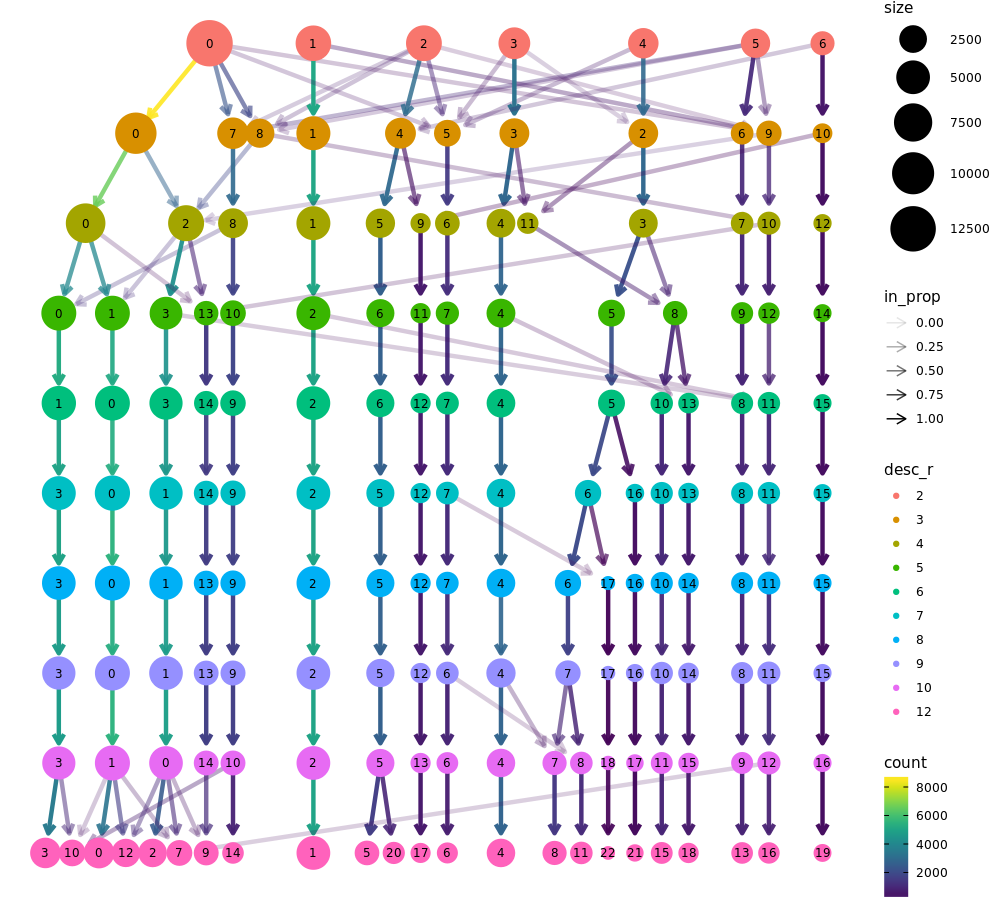

In [18]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="desc_r",suffix = "_clusters")

In [19]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [20]:
def run_vis(adata):
    if 'X_emb' in adata.obsm:
        sc.pp.neighbors(adata, use_rep='X_emb',n_neighbors=10, n_pcs=33)
        sc.tl.umap(adata)
    else:
        sc.pp.pca(adata, svd_solver='arpack')
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)

In [81]:
adata.obsm['X_emb'] = adata.obsm['X_Embeded_z'+str(0.5)]

In [82]:
run_vis(adata)

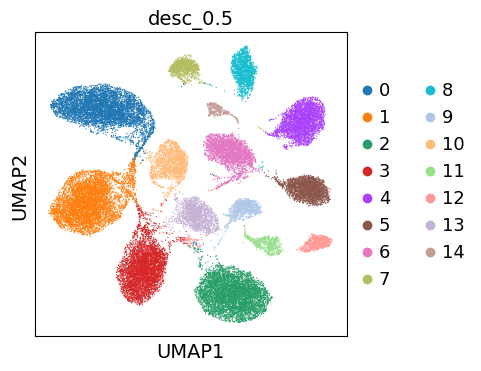

In [99]:
sc.pl.umap(adata, color=['desc_0.5'],color_map=mymap)

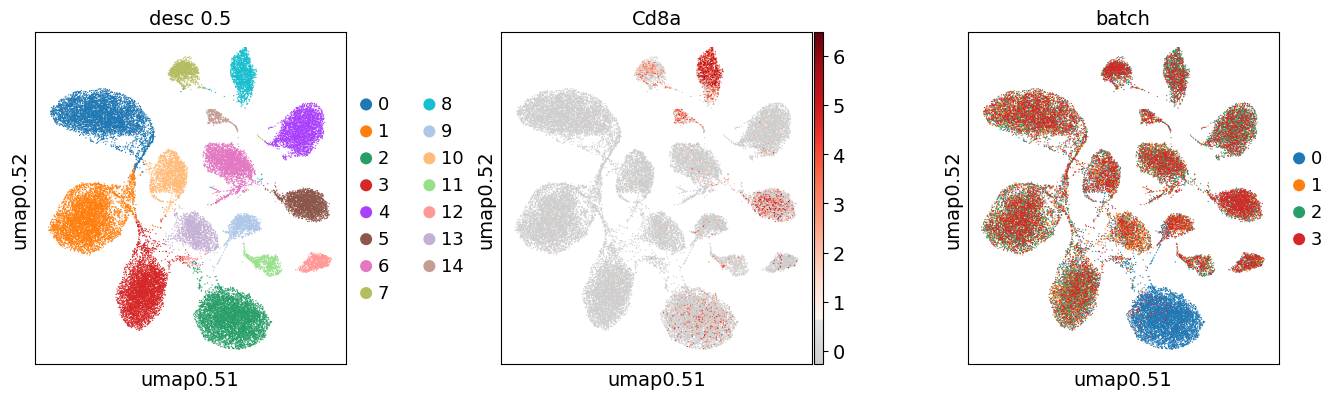

In [100]:
sc.pl.scatter(adata,basis="umap0.5",color=['desc_0.5','Cd8a','batch'],color_map=mymap)

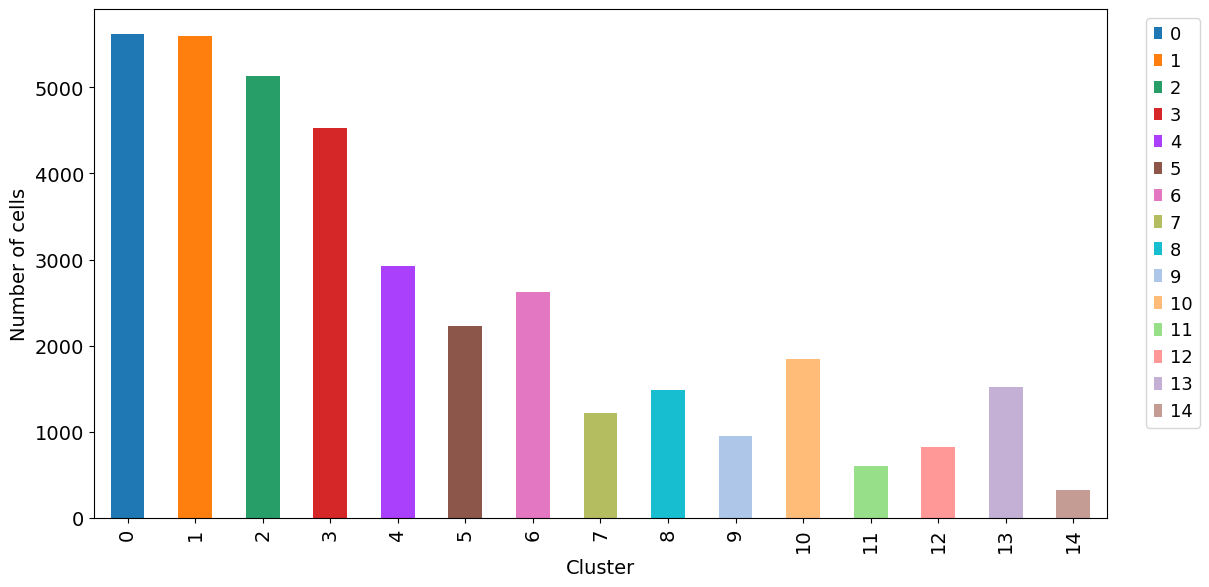

In [85]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.5")["desc_0.5"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

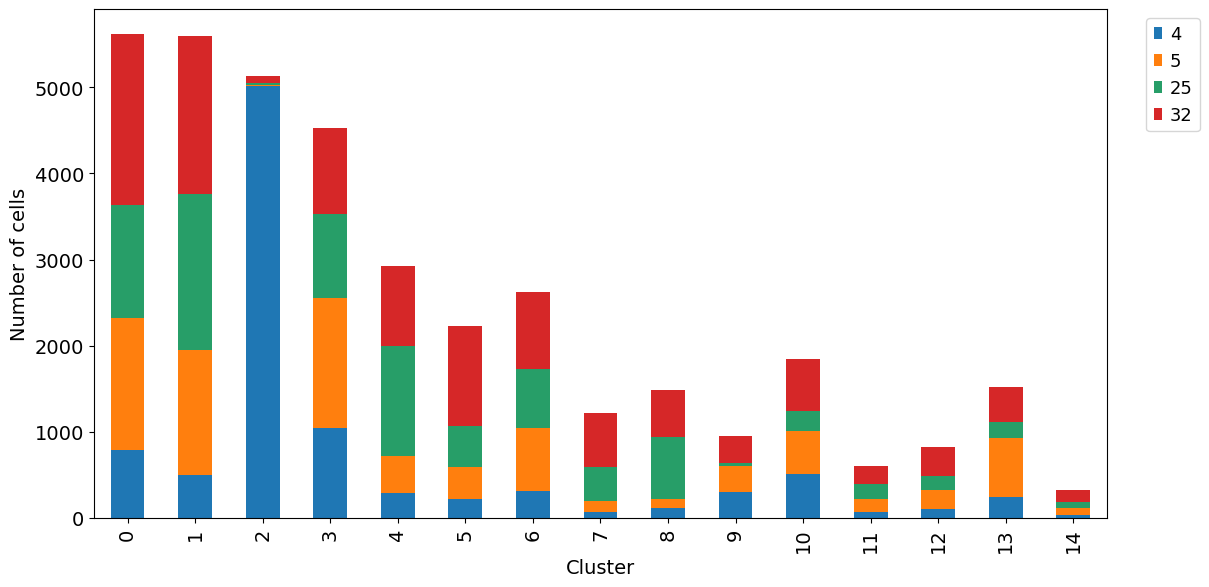

In [86]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.5")["MouseID"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

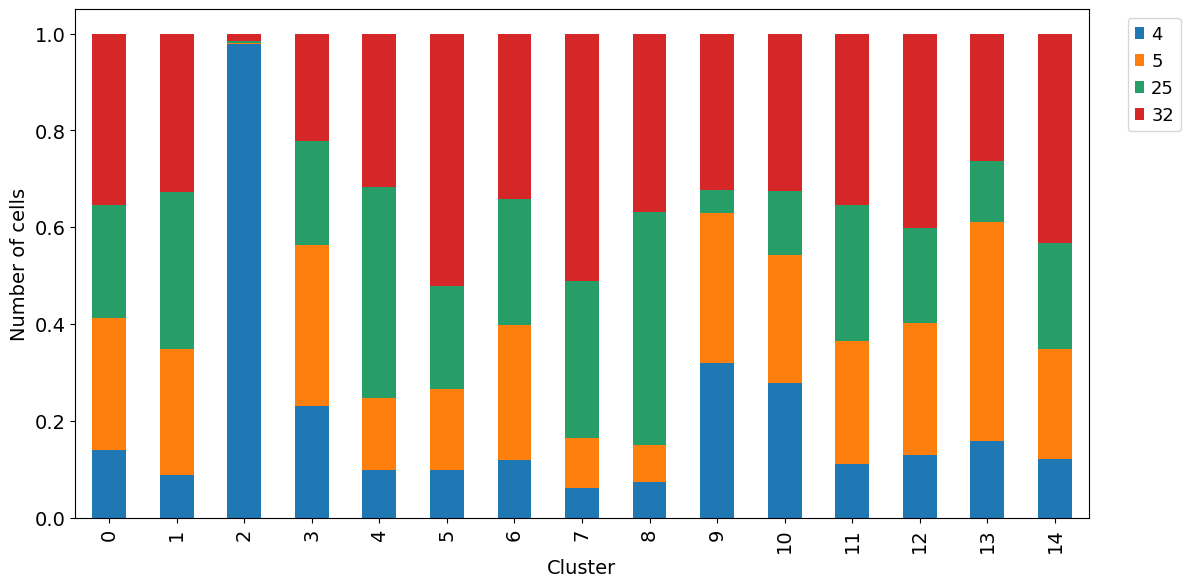

In [87]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.5")["MouseID"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

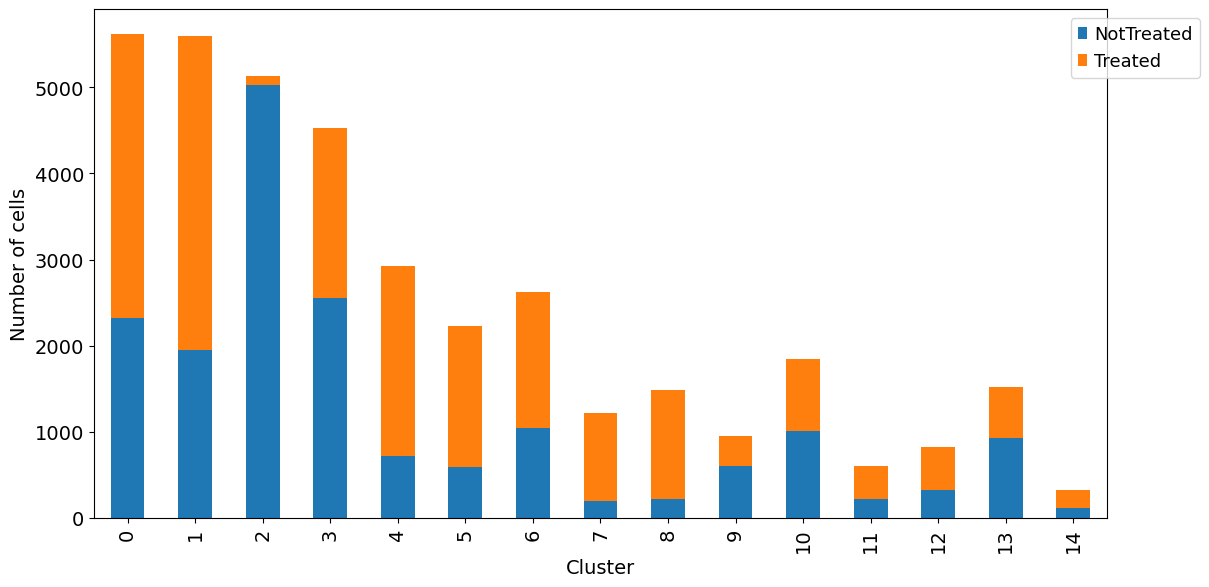

In [88]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.5")["Treatment"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

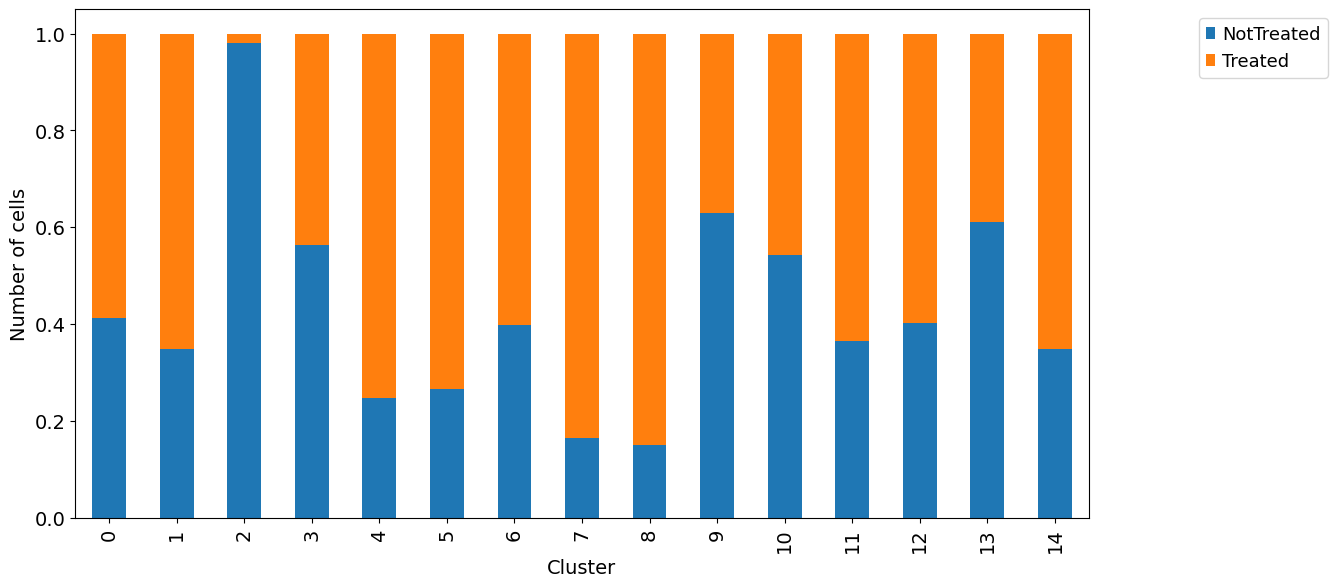

In [89]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.5")["Treatment"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

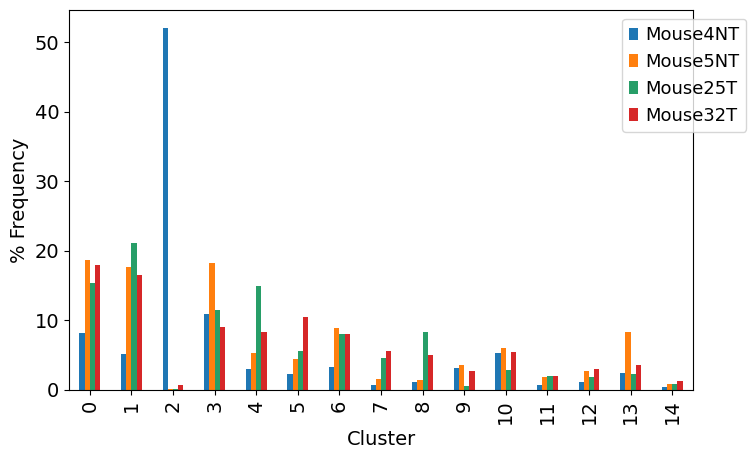

In [90]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))
#
ax1 = (pd.crosstab(adata.obs["desc_0.5"], adata.obs.SampleID,normalize='columns')*100).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

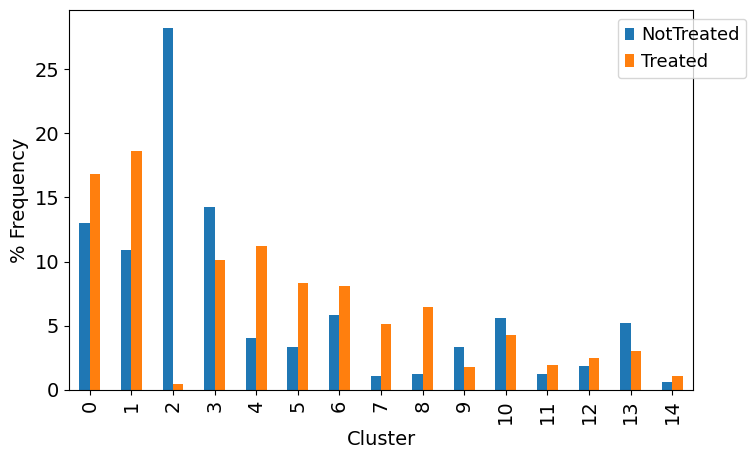

In [91]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))
#
ax1 = (pd.crosstab(adata.obs["desc_0.5"], adata.obs.Treatment,normalize='columns')*100).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

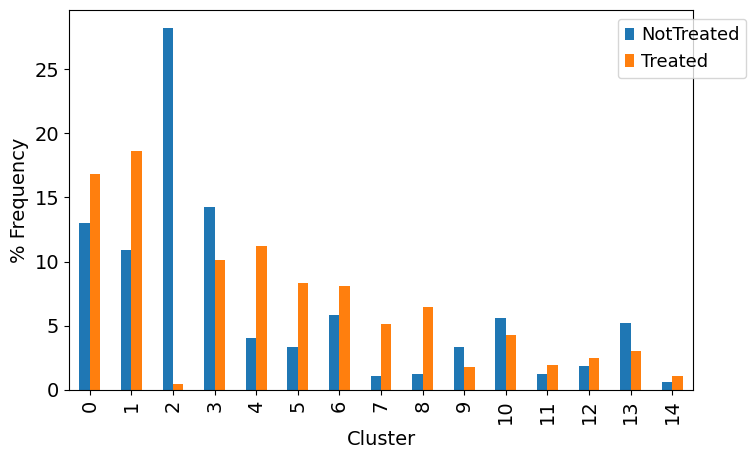

In [92]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))
#
ax1 = (pd.crosstab(adata.obs["desc_0.5"], adata.obs.Treatment,normalize='columns')*100).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))


In [129]:
adata

AnnData object with n_obs × n_vars = 37428 × 16563
    obs: 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_disaggregation_score', 'pct_counts_disaggregation_score', 'total_counts_rb', 'pct_counts_rb', 'n_genes', 'SampleID', 'Treatment', 'MouseID', 'batch', 'S_score', 'G2M_score', 'phase', 'desc_0.2', 'desc_0.3', 'desc_0.4', 'desc_0.5', 'desc_0.6', 'desc_0.7', 'desc_0.8', 'desc_0.9', 'desc_1.0', 'desc_1.2'
    var: 'gene_ids', 'feature_types', 'mt', 'disaggregation_score', 'rb', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-1', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells-2', 'n_cells_by_counts-3', 'mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3', 'n_cells-3', 'highly_variable', 'means', 'dispersions', 'd

In [130]:
sc.tl.rank_genes_groups(adata, 'desc_0.5', method='wilcoxon',use_raw=False,layer='norm_data')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Lyz2,Ms4a6d,S100a9,Aif1,AW112010,Cd3d,Cd74,Il2rb,Trbc2,S100a9,Gngt2,Tmem123,Gm42418,Lgals3,Tcf4
1,Smpdl3a,Fcgr1,Actb,Lgmn,Il2rb,Cd3g,H2-Ab1,Cd2,Cd3g,S100a8,Dusp16,Ccr7,AY036118,Tpi1,Cyb561a3
2,Gsr,Tspo,S100a8,C3ar1,Nkg7,Trac,H2-Aa,Gimap6,Cd3d,Srgn,Cebpb,Syngr2,Apoe,Aldoa,Siglech
3,Hp,Plac8,Ccl4,Ms4a7,Klre1,Trbc2,H2-Eb1,Ets1,Thy1,Clec4d,Trib1,Tbc1d4,C1qb,Pgk1,Bst2
4,Psap,Ms4a4c,Dusp1,Cd300c2,Irf8,H2-Q7,H2-DMb1,Gimap3,Nkg7,Cd9,Pou2f2,Relb,Lars2,Bnip3,Ighm
5,Mgst1,Npc2,Cxcl2,Ctss,Ctla2a,Cd3e,H2-DMa,Gimap4,Cd3e,Hcar2,Treml4,Lsp1,C1qa,Fth1,St8sia4
6,Msrb1,Prdx5,Ccl3,Fcer1g,Ctsw,Ifngr1,Syngr2,Trbc2,Trac,Hdc,Ear2,Mmp25,C1qc,Ero1l,Ccr9
7,Aldh2,Tgfbi,Hspa1a,Apoe,Gzmb,Ets1,Ccnd1,Sh2d2a,Ms4a4b,Il1r2,Cybb,Cd63,Cd79a,Pgam1,Rell1
8,Ifitm6,Ifitm3,Gm42418,Grn,Txk,H2-K1,Ifi30,Vgll4,Sh2d2a,Ccr1,Cyp4f18,Samsn1,Gm26917,Npc2,Blnk
9,Samhd1,Ctss,Zfp36,Cxcl16,Prf1,Cd2,Ckb,Lck,Ptprcap,Acod1,Msrb1,Socs2,Ebf1,Gapdh,Dnajc7


In [102]:
sc.tl.dendrogram(adata, 'desc_0.5')

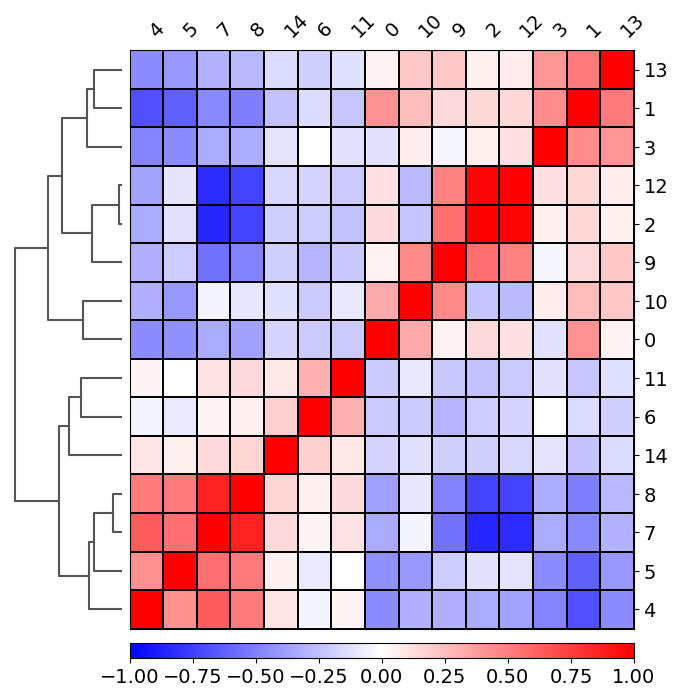

In [103]:
ax = sc.pl.correlation_matrix(adata, 'desc_0.5', figsize=(8,8))

In [131]:
result = adata.uns['rank_genes_groups']

In [132]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
    for group in groups for key in ['names','pvals','pvals_adj','logfoldchanges']}).to_csv("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/Data_integrated_Res05.csv",header=True,index=False)

#### Resolution 2

In [133]:
adata.obsm['X_emb'] = adata.obsm['X_Embeded_z'+str(0.2)]

In [134]:
run_vis(adata)

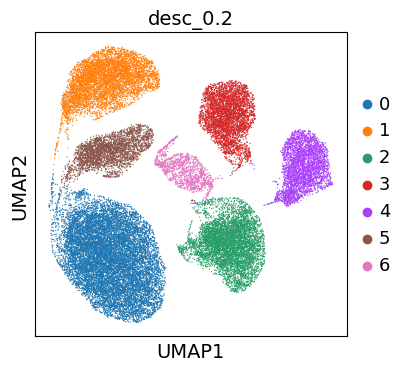

In [135]:
sc.pl.umap(adata, color=['desc_0.2'],color_map=mymap)

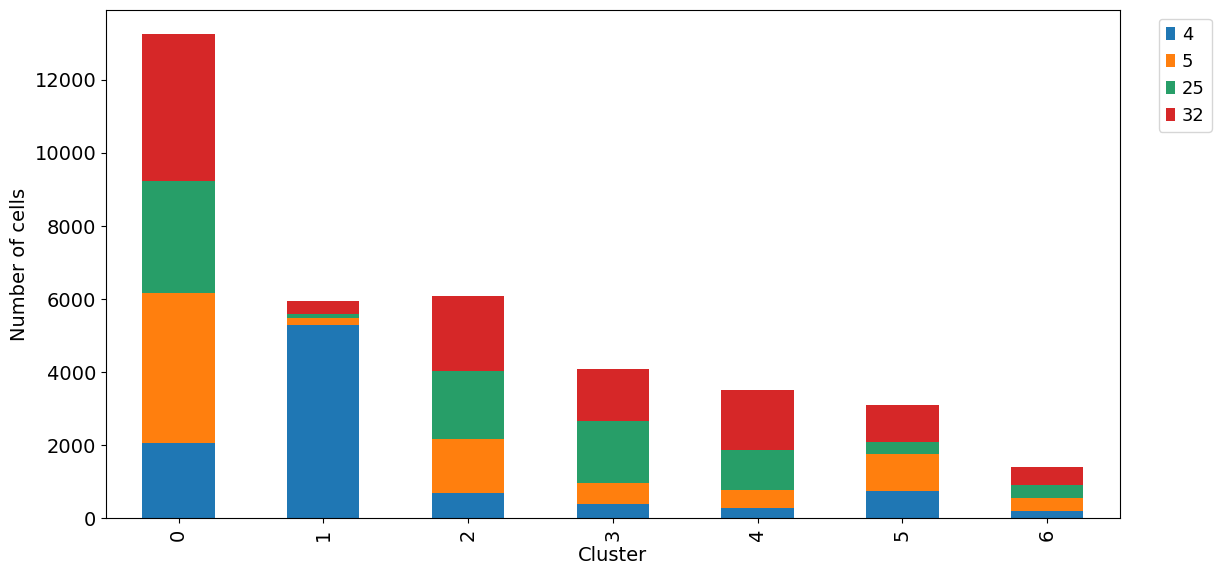

In [136]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.2")["MouseID"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

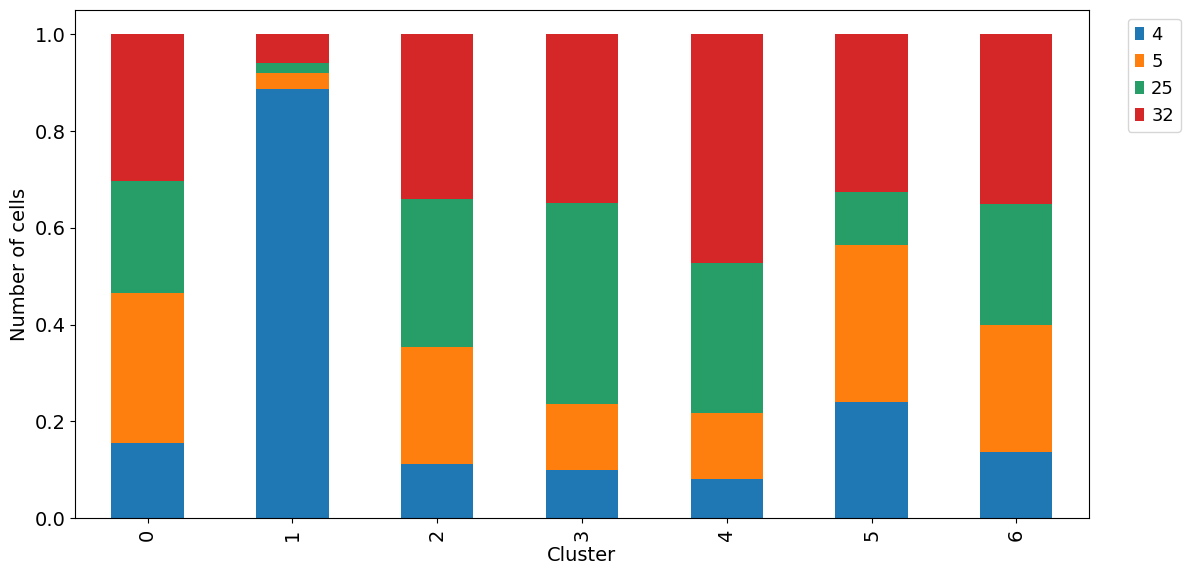

In [137]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.2")["MouseID"].value_counts(normalize=True).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of cells")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

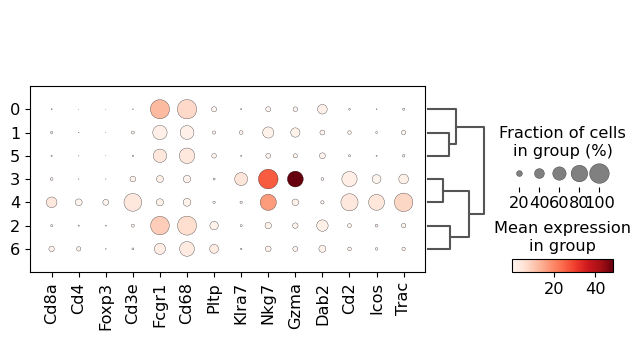

In [138]:
rcParams['figure.figsize'] = 10,10
sc.pl.dotplot(adata, ['Cd8a','Cd4','Foxp3','Cd3e','Fcgr1','Cd68','Pltp','Klra7','Nkg7','Gzma','Dab2','Cd2','Icos','Trac'], 'desc_0.2', dendrogram=True)

In [141]:
sc.tl.rank_genes_groups(adata, 'desc_0.2', method='wilcoxon',use_raw=False,layer='norm_data')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

,0,1,2,3,4,5,6
0,Lyz2,S100a9,Cd74,Il2rb,Cd3d,Clec4d,Syngr2
1,Plac8,Actb,H2-DMb1,Nkg7,Cd3g,Cd9,Ptms
2,Ifitm3,S100a8,H2-DMa,AW112010,Trac,Hcar2,St8sia4
3,Prdx5,Ccl4,H2-Ab1,Ctsw,Trbc2,S100a8,Pkib
4,Lgals3,Dusp1,H2-Aa,Ctla2a,Cd3e,S100a9,Ctsh
5,Ms4a6d,Gm42418,Ifi30,Txk,Ets1,Ets2,Lsp1
6,Mafb,Ccl3,H2-Eb1,Gzmb,H2-Q7,Cebpb,Ppia
7,Fcgr1,Hspa1a,Syngr2,Klre1,Cd2,Slfn4,Tmem123
8,Ms4a6c,Cxcl2,Plbd1,Ms4a4b,Ltb,Acod1,Herpud1
9,Tgfbi,Fos,Ccnd1,Sh2d2a,Tnfrsf18,Grina,Ncf1


In [142]:
result = adata.uns['rank_genes_groups']

In [143]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
    for group in groups for key in ['names','pvals','pvals_adj','logfoldchanges']}).to_csv("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/Data_integrated_Res02.csv",header=True,index=False)

In [145]:
sc.tl.dendrogram(adata, 'desc_0.2')